In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
import warnings
import re
import random
import os, hashlib

import tensorflow.keras as keras
import tensorflow as tf
from PIL import Image
from keras import activations
from keras.layers import Input, Conv2D, Dense, Flatten, MaxPooling2D, Input, AveragePooling2D, Dropout
from keras.layers import GlobalAveragePooling2D, BatchNormalization, Activation, Add, ZeroPadding2D, MaxPool2D
from keras.models import Model, Sequential
from keras.layers import concatenate
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.layers import Lambda
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.initializers import GlorotUniform
from sklearn.metrics import confusion_matrix

warnings.filterwarnings("ignore")
print('tensorflow ' + tf. __version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

tensorflow 2.10.0
Num GPUs Available:  1


# Import Data

In [2]:
PROJECT_DIR = ''
DATASET_PATH = PROJECT_DIR + 'dataset/Flowers/'
EXPORT_DIR = PROJECT_DIR + 'model/'

# Image settings
IMAGE_WIDTH = 160
IMAGE_HEIGHT = 160
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS = 3
INPUT_SHAPE = (IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)

categories = ['Babi', 'Calimero', 'Chrysanthemum', 'Hydrangeas', 'Lisianthus', 'Pingpong', 'Rosy', 'Tana']

In [3]:
#os.rename("dataset/Flowers/Calimerio", ("dataset/Flowers/Calimero"))

In [4]:
# Add class name prefix to filename. So for example "/babi_1.jpg" become "Babi/babi_1.jpg"
def add_class_name_prefix(df, col_name):
    df[col_name] = df[col_name].apply(lambda x: x[:re.search("_",x).start()].capitalize() + '/' + x)
    return df

# list conatining all the filenames in the dataset
filenames_list = []
# list to store the corresponding category, note that each folder of the dataset has one class of data
categories_list = []

for category in categories:
    filenames = os.listdir(DATASET_PATH + category)    
    filenames_list = filenames_list + filenames
    categories_list = categories_list + [category] * len(filenames)

df = pd.DataFrame({
    'filename': filenames_list,
    'category': categories_list,
})

df = add_class_name_prefix(df, 'filename')

# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)

print('number of elements = ' , len(df))    


number of elements =  4621


In [5]:
df.head()

,filename,category
0,Babi/babi_150.jpg,Babi
1,Lisianthus/lisianthus_782.jpg,Lisianthus
2,Hydrangeas/hydrangeas_112.jpg,Hydrangeas
3,Chrysanthemum/chrysanthemum_167.jpg,Chrysanthemum
4,Hydrangeas/hydrangeas_441.jpg,Hydrangeas


Lisianthus/lisianthus_273.jpg


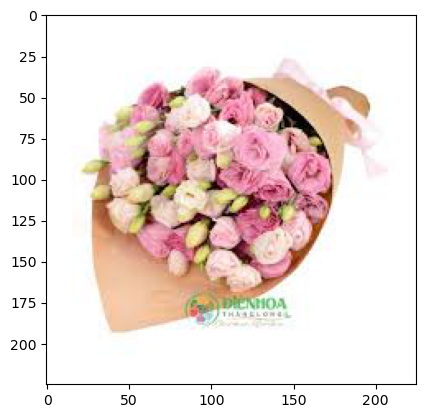

In [6]:
# Show random images
random_row = random.randint(0, len(df)-1)
sample = df.iloc[random_row]
randomimage = keras.utils.load_img(DATASET_PATH + sample['filename'])
print(sample['filename']) 
plt.imshow(randomimage)

# Exploratory Data Analysis (EDA)

### Check image duplication

In [7]:
duplicate_files = []
duplicates = []
hash_keys = dict()

for category in categories:
    folder = DATASET_PATH + category
    for _ , filename in  enumerate(os.listdir(folder)):
        with open(folder + '/' + filename, 'rb') as f:
            filehash = hashlib.md5(f.read()).hexdigest()
            file = folder + '/' + filename
        if filehash not in hash_keys: 
            hash_keys[filehash] = file
        else:
            duplicate_files.append(file)
            duplicates.append(category + '/' + filename)
            print("{}\t{}".format(file, hash_keys[filehash]))

dataset/Flowers/Babi/babi_197.jpg	dataset/Flowers/Babi/babi_196.jpg
dataset/Flowers/Babi/babi_223.jpg	dataset/Flowers/Babi/babi_222.jpg
dataset/Flowers/Babi/babi_236.jpg	dataset/Flowers/Babi/babi_235.jpg
dataset/Flowers/Babi/babi_244.jpg	dataset/Flowers/Babi/babi_243.jpg
dataset/Flowers/Babi/babi_418.jpg	dataset/Flowers/Babi/babi_357.jpg
dataset/Flowers/Babi/babi_423.jpg	dataset/Flowers/Babi/babi_422.jpg
dataset/Flowers/Babi/babi_426.jpg	dataset/Flowers/Babi/babi_342.jpg
dataset/Flowers/Babi/babi_450.jpg	dataset/Flowers/Babi/babi_372.jpg
dataset/Flowers/Babi/babi_490.jpg	dataset/Flowers/Babi/babi_483.jpg
dataset/Flowers/Babi/babi_495.jpg	dataset/Flowers/Babi/babi_442.jpg
dataset/Flowers/Babi/babi_528.jpg	dataset/Flowers/Babi/babi_338.jpg
dataset/Flowers/Babi/babi_570.jpg	dataset/Flowers/Babi/babi_365.jpg
dataset/Flowers/Babi/babi_75.jpg	dataset/Flowers/Babi/babi_221.jpg
dataset/Flowers/Babi/babi_785.jpg	dataset/Flowers/Babi/babi_774.jpg
dataset/Flowers/Babi/babi_811.jpg	dataset/Flowers

Remove duplicate images from dataframe to keep the ensure each data point (image) is represented only a single time. If not the CNN may learn to be biased towards the duplicate images.

In [8]:
# for filename in duplicate_files:
#     os.remove(filename)
   
for filename in duplicates:
    df.drop(df[df['filename'] == filename].index, inplace=True)

## Check data balance

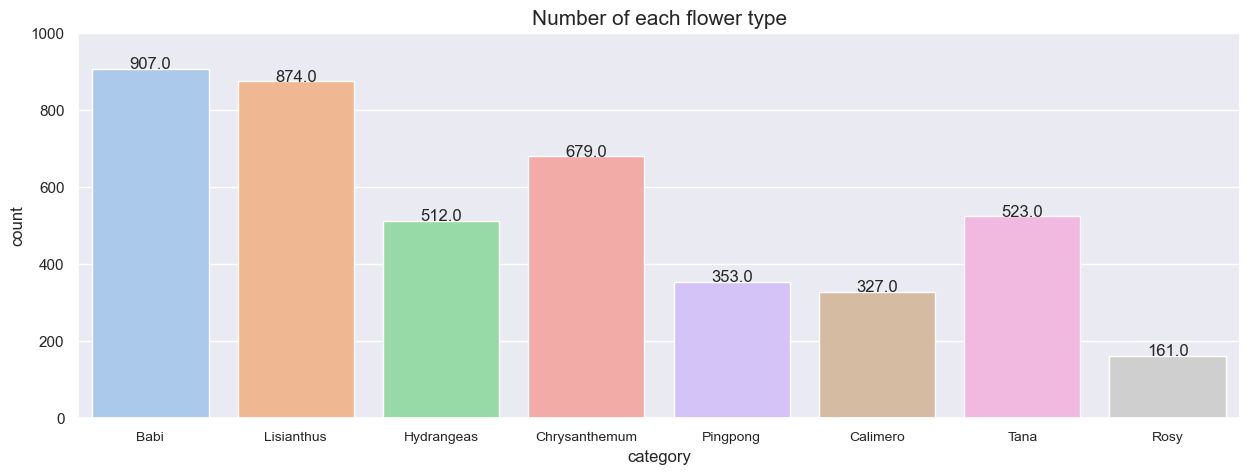

In [9]:
sns.set_theme(style="darkgrid")
fig, ax1 = plt.subplots(figsize = (15 , 5))
graph = sns.countplot(ax=ax1,x='category', data=df, palette='pastel')
graph.set_title("Number of each flower type", fontsize=15)
graph.set_xticklabels(graph.get_xticklabels(),rotation=0, fontsize=10)
ax1.set_ylim([0, 1000])
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height, height, ha="center")

# Data Processing

Split data into training set (80%), validation set (10%), and test set (10%)

In [10]:
train_df, test_df = train_test_split(df, stratify=df['category'], test_size=0.2, random_state=0)
val_df, test_df = train_test_split(test_df, stratify=test_df['category'], test_size=0.5, random_state=0)
print("Train data : {}, Val Data: {}, Test Data: {}".format(train_df.shape[0], val_df.shape[0], test_df.shape[0]))

Train data : 3468, Val Data: 434, Test Data: 434


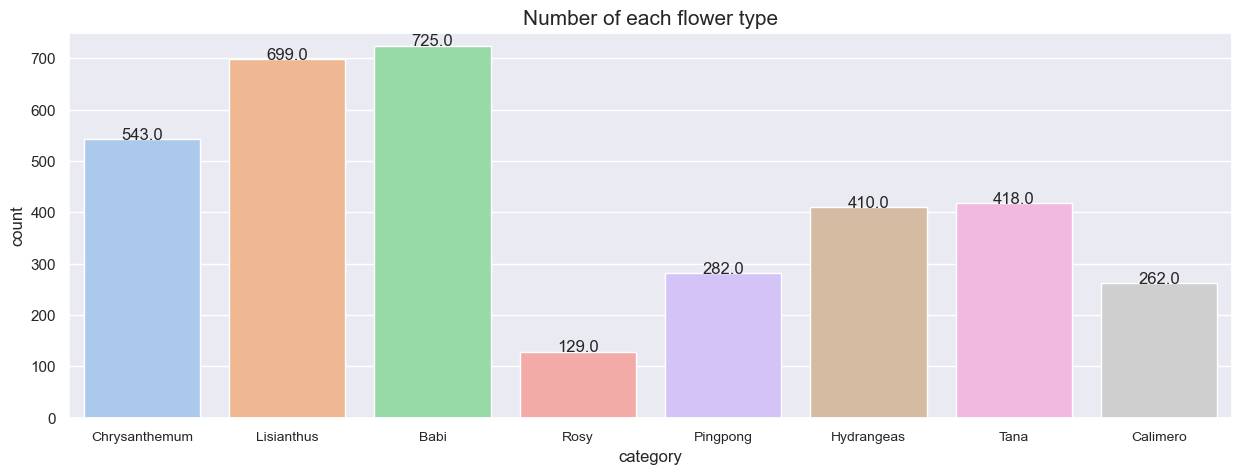

In [11]:
sns.set_theme(style="darkgrid")
fig, ax1 = plt.subplots(figsize = (15 , 5))
graph = sns.countplot(ax=ax1,x='category', data=train_df, palette='pastel')
graph.set_title("Number of each flower type", fontsize=15)
graph.set_xticklabels(graph.get_xticklabels(),rotation=0, fontsize=10)
ax1.set_ylim([0, 750])
for p in graph.patches:
    height = p.get_height()
    graph.text(p.get_x()+p.get_width()/2., height, height, ha="center")

Since the amount of images from each category are not equal, varying from 129 to 725 in the train set, we need to sample the filenames from the train dataframe based on the highest frequency flower to make data augmentation applied equally on all categories.

In [12]:
class_count = train_df['category'].value_counts()
train_df_resampled = train_df[train_df['category'] == 'Babi']

for name in class_count.keys():
    if (name == 'Babi'): continue
    df_class = train_df[train_df['category'] == name].sample(class_count['Babi'], replace=True, random_state=0)
    train_df_resampled = pd.concat([train_df_resampled, df_class], axis=0)
train_df_resampled = train_df_resampled.sample(frac=1).reset_index(drop=True)
print(train_df_resampled['category'].value_counts())

Rosy             725
Calimero         725
Tana             725
Lisianthus       725
Pingpong         725
Chrysanthemum    725
Hydrangeas       725
Babi             725
Name: category, dtype: int64


Applying data augmentation onto the train set. Validation set and test set will remain normal.

In [13]:
def get_df_generator(df, augmentation=False):
    generator = image.ImageDataGenerator(rescale = 1./255)
    
    if augmentation == True:
        generator = image.ImageDataGenerator(
            rescale = 1./255, 
            rotation_range = 90,
            width_shift_range=0.25,
            height_shift_range=0.25,
            zoom_range=0.25,
            shear_range=0.1,
            horizontal_flip=True) 
    
    iterator = generator.flow_from_dataframe(
        dataframe = df,
        directory = DATASET_PATH, 
        x_col = "filename",
        y_col = "category",
        classes = categories, 
        class_mode = "categorical", 
        target_size = IMAGE_SIZE, 
        batch_size = 32,
        color_mode = "rgb",
        shuffle=True,
    )

    return iterator

In [14]:
train_gen = get_df_generator(train_df_resampled, augmentation=True)
val_gen = get_df_generator(val_df)
test_gen = get_df_generator(test_df)

Found 5800 validated image filenames belonging to 8 classes.
Found 434 validated image filenames belonging to 8 classes.
Found 434 validated image filenames belonging to 8 classes.


Displaying 5 example images that have been augmented from the training set

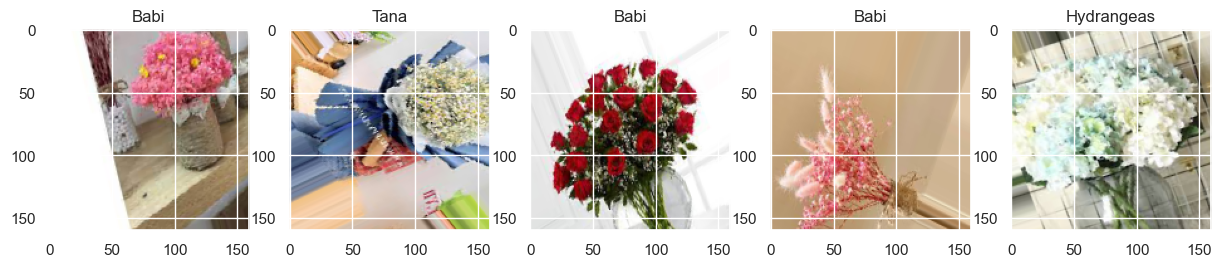

In [219]:
columns = 5
rows = 1
fig = plt.figure(figsize=(15, 15))

for i in range(columns*rows):
    img, label = train_gen.next()
    fig.add_subplot(rows, columns, i+1)
    plt.title(categories[np.argmax(label[0])])
    plt.imshow(img[0])

plt.show()

# AlexNet

In [15]:
# https://towardsdatascience.com/implementing-alexnet-cnn-architecture-using-tensorflow-2-0-and-keras-2113e090ad98
def AlexNet():
    model = keras.models.Sequential([
        keras.layers.Conv2D(filters=96, kernel_size=(1,1), strides=(1,1), activation='relu', input_shape=INPUT_SHAPE),
        keras.layers.BatchNormalization(),
        
        keras.layers.Conv2D(filters=96, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),

        keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
        
        keras.layers.Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),
                
        keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
        keras.layers.BatchNormalization(),
        keras.layers.MaxPool2D(pool_size=(3,3), strides=(2,2)),

        # Pass it to Fully Connected layer and output layer
        keras.layers.Flatten(),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(4096, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(1000, activation='relu'),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(8, activation='softmax' , kernel_regularizer=l2(0.001))
    ])

    return model

Define the metrics to evaluate the model. 

In [16]:
# https://neptune.ai/blog/implementing-the-macro-f1-score-in-keras

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

METRICS = ['accuracy', f1_m]

In [17]:
model_alexnet = AlexNet()
model_alexnet.compile(optimizer="SGD", loss="categorical_crossentropy", metrics=METRICS)
model_alexnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 160, 160, 96)      384       
                                                                 
 batch_normalization (BatchN  (None, 160, 160, 96)     384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 160, 160, 96)      83040     
                                                                 
 batch_normalization_1 (Batc  (None, 160, 160, 96)     384       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 79, 79, 96)       0         
 )                                                               
                                                        

In [18]:
def fit_model(model, iterator, val_iterator, epochs = 200, export_dir = EXPORT_DIR, name = 'default'):
    es = EarlyStopping(monitor='val_f1_m', 
                       mode='max', 
                       verbose=1, 
                       patience=20, 
                       restore_best_weights=True)
    mc = ModelCheckpoint('{}/model_{}.h5'.format(EXPORT_DIR, name), 
                         monitor='val_f1_m', 
                         mode='max', 
                         save_best_only=True)
    history = model.fit_generator(
        iterator,
        validation_data = val_iterator,
        epochs = epochs,
        verbose = 1,
        callbacks=[mc,es]
    )
    return history

In [19]:
history_alexnet = fit_model(model_alexnet, train_gen, val_gen, name="AlexNet")

Epoch 1/200
182/182 [==============================] - 52s 237ms/step - loss: 2.3513 - accuracy: 0.2259 - f1_m: 0.1085 - val_loss: 2.4427 - val_accuracy: 0.2074 - val_f1_m: 0.0000e+00
Epoch 2/200
182/182 [==============================] - 39s 213ms/step - loss: 1.7645 - accuracy: 0.3178 - f1_m: 0.1845 - val_loss: 2.4397 - val_accuracy: 0.1567 - val_f1_m: 0.1033
Epoch 3/200
182/182 [==============================] - 39s 212ms/step - loss: 1.6209 - accuracy: 0.3636 - f1_m: 0.2351 - val_loss: 2.2452 - val_accuracy: 0.2949 - val_f1_m: 0.2925
Epoch 4/200
182/182 [==============================] - 39s 214ms/step - loss: 1.5406 - accuracy: 0.4076 - f1_m: 0.2883 - val_loss: 1.7204 - val_accuracy: 0.4009 - val_f1_m: 0.3565
Epoch 5/200
182/182 [==============================] - 40s 217ms/step - loss: 1.4546 - accuracy: 0.4397 - f1_m: 0.3304 - val_loss: 1.4948 - val_accuracy: 0.4908 - val_f1_m: 0.3944
Epoch 6/200
182/182 [==============================] - 42s 231ms/step - loss: 1.3889 - accuracy:

In [224]:
evaluation_alexnet = model_alexnet.evaluate(val_gen)

14/14 [==============================] - 1s 59ms/step - loss: 0.9008 - accuracy: 0.7535 - f1_m: 0.7662


In [20]:
evaluation_alexnet = model_alexnet.evaluate(test_gen)

14/14 [==============================] - 3s 230ms/step - loss: 0.8734 - accuracy: 0.7327 - f1_m: 0.7472


In [71]:
def plot_model_history(history, 
                       params=['f1_m', 'loss'],
                       model_name='model_name'):
    params_count = len(params)
    plt.figure(figsize=(7*params_count, 4))
    for index, param in enumerate(params):
        epochs = range(len(history.history[param]))
        plt.subplot(1, params_count, index + 1)
        plt.plot(epochs, history.history[param], 'red', label='Training ' + param)
        plt.plot(epochs, history.history['val_' + param], 'purple', label='Validation ' + param)
        plt.title('Training and validation {} of {}'.format(param, model_name))
        plt.legend()
    plt.show()

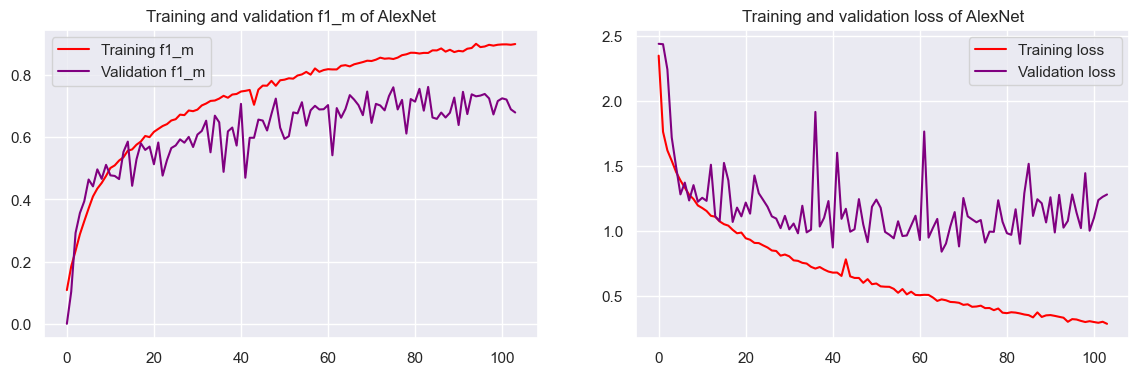

In [72]:
plot_model_history(history_alexnet, model_name='AlexNet')

# ResNet50

In [80]:
# https://medium.com/analytics-vidhya/understanding-and-implementation-of-residual-networks-resnets-b80f9a507b9c
def identity_block(X, f, filters, block, activation='relu'):
    """
    Implementation of the identity block
    
    Arguments:
    X: input tensor
    f: shape for middle CONV kernel size param
    filters: list of number of filters in the CONV layers of the main path
    block: name of this block
    
    Returns:
    X: output, returns a tensor
    """
    
    
    conv_name = 'conv' + block
    bn_name = 'batchNorm' + block
    
    # get filters from parameter
    F1, F2, F3 = filters
    
    # copy the original shape to add it back to the main path
    X_copy = X
    
    # First component of main path
    X = Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name + 'a', kernel_initializer = GlorotUniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name + 'a')(X)
    X = Activation(activation)(X)
    
    
    # Second component of main path
    X = Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name + 'b', kernel_initializer = GlorotUniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name + 'b')(X)
    X = Activation(activation)(X)

    # Third component of main path 
    X = Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name + 'c', kernel_initializer = GlorotUniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name + 'c')(X)

    # add shortcut back to main path, and use relu activation
    X = Add()([X, X_copy])
    X = Activation(activation)(X)
    
    return X

In [81]:
def convolutional_block(X, f, filters, block, s = 2, activation='relu'):
    """
    Implementation of the convolutional block
    
    Arguments:
    X: input tensor
    f: shape for middle CONV kernel size param
    filters: list of number of filters in the CONV layers of the main path
    block: name of this block
    s: stride param to be used for shortcut component
    
    Returns:
    X: output, returns a tensor

    """

    conv_name = 'conv' + block
    bn_name = 'batchNorm' + block
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_copy = X

    # First component
    X = Conv2D(F1, (1, 1), strides = (s,s), name = conv_name + 'a', kernel_initializer  = GlorotUniform(seed= 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name + 'a')(X)
    X = Activation(activation)(X)

    # Second component
    X = Conv2D(F2, (f,f), strides = (1,1), padding = 'same', name = conv_name + 'b', kernel_initializer = GlorotUniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name + 'b')(X)
    X = Activation(activation)(X)

    # Third component
    X = Conv2D(F3, (1,1), strides = (1,1), padding = 'valid', name = conv_name + 'c', kernel_initializer = GlorotUniform(seed = 0))(X)
    X = BatchNormalization(axis = 3, name = bn_name + 'c')(X)

    # Shortcut
    X_copy = Conv2D(F3, (1,1), strides = (s,s), padding = 'valid', name = conv_name + 'd', kernel_initializer = GlorotUniform(seed = 0))(X_copy)
    X_copy = BatchNormalization(axis = 3, name = bn_name + 'd')(X_copy)

    # add shortcut back to main path, and use relu activation
    X = Add()([X, X_copy])
    X = Activation(activation)(X)
    
    return X

In [82]:
from keras.regularizers import l2

def ResNet50(input_shape = INPUT_SHAPE, classes = 8):
    """
    Implementation of ResNet50 using this architecture:
    CONV2D -> BATCHNORM -> CONV2D -> BATCHNORM -> MAXPOOL -> CONVBLOCK -> IDBLOCK*3 -> CONVBLOCK -> IDBLOCK*1
    -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape: shape of the images of the dataset
    classes: integer, number of output labels

    Returns:
    model: a Model() instance in Keras
    """
    
    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Stage 1
    X = Conv2D(96, 1, 1, activation='relu')(X_input)
    X = BatchNormalization(axis = 3)(X)
    X = Conv2D(64, 7, 1, kernel_initializer = GlorotUniform(seed=0), activation='relu')(X)
    X = BatchNormalization(axis = 3)(X)
    X = MaxPooling2D(3, 2)(X)

    # Stage 2
    X = convolutional_block(X, 3, filters = [128, 128, 512], block='2a', s = 2)
    X = identity_block(X, 3, [128, 128, 512], block='2b')
    X = identity_block(X, 3, [128, 128, 512], block='2c')
    X = identity_block(X, 3, [128, 128, 512], block='2d')

    # Stage 3
    X = convolutional_block(X, 3, filters = [256, 256, 1024], block='3a', s = 2)
    X = identity_block(X, 3, [256, 256, 1024], block='3b')

    # Stage 4 
    X = convolutional_block(X, 3, filters = [512, 512, 2048], block='4a', s = 2)
    X = identity_block(X, 3, [512, 512, 2048], block='4b')
    X = identity_block(X, 3, [512, 512, 2048], block='4c')

    # AVGPOOL
    X = AveragePooling2D()(X)

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer = GlorotUniform(seed=0) , kernel_regularizer=l2(0.01))(X)
    
    
    # Create model
    model = Model(inputs = X_input, outputs = X, name='ResNet50')

    return model

In [83]:
model_resnet50 = ResNet50()

In [84]:
opt = Adam(lr=0.0005, amsgrad = True) 
model_resnet50.compile(optimizer=opt, loss="categorical_crossentropy", metrics=METRICS)
model_resnet50.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 160, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 160, 160, 96  384         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 160, 160, 96  384        ['conv2d_5[0][0]']               
 rmalization)                   )                                                          

In [85]:
history_restnet50 = fit_model(model_resnet50, train_gen, val_gen, name='ResNet50')

Epoch 1/200
182/182 [==============================] - 80s 405ms/step - loss: 5.7103 - accuracy: 0.1967 - f1_m: 0.0897 - val_loss: 2.5345 - val_accuracy: 0.1982 - val_f1_m: 0.0000e+00
Epoch 2/200
182/182 [==============================] - 68s 373ms/step - loss: 2.3485 - accuracy: 0.2966 - f1_m: 0.1473 - val_loss: 2.9301 - val_accuracy: 0.2696 - val_f1_m: 0.1775
Epoch 3/200
182/182 [==============================] - 67s 367ms/step - loss: 1.9474 - accuracy: 0.3548 - f1_m: 0.1803 - val_loss: 1.8646 - val_accuracy: 0.3571 - val_f1_m: 0.3200
Epoch 4/200
182/182 [==============================] - 67s 369ms/step - loss: 1.7660 - accuracy: 0.3952 - f1_m: 0.2363 - val_loss: 1.5567 - val_accuracy: 0.5023 - val_f1_m: 0.4053
Epoch 5/200
182/182 [==============================] - 65s 358ms/step - loss: 1.6610 - accuracy: 0.4317 - f1_m: 0.2816 - val_loss: 1.6562 - val_accuracy: 0.4585 - val_f1_m: 0.3904
Epoch 6/200
182/182 [==============================] - 66s 360ms/step - loss: 1.5698 - accuracy:

In [86]:
evaluation_resnet50 = model_resnet50.evaluate(val_gen)

14/14 [==============================] - 1s 88ms/step - loss: 1.1148 - accuracy: 0.7189 - f1_m: 0.7161


In [87]:
evaluation_resnet50 = model_resnet50.evaluate(test_gen)

14/14 [==============================] - 3s 227ms/step - loss: 1.2315 - accuracy: 0.6728 - f1_m: 0.6720


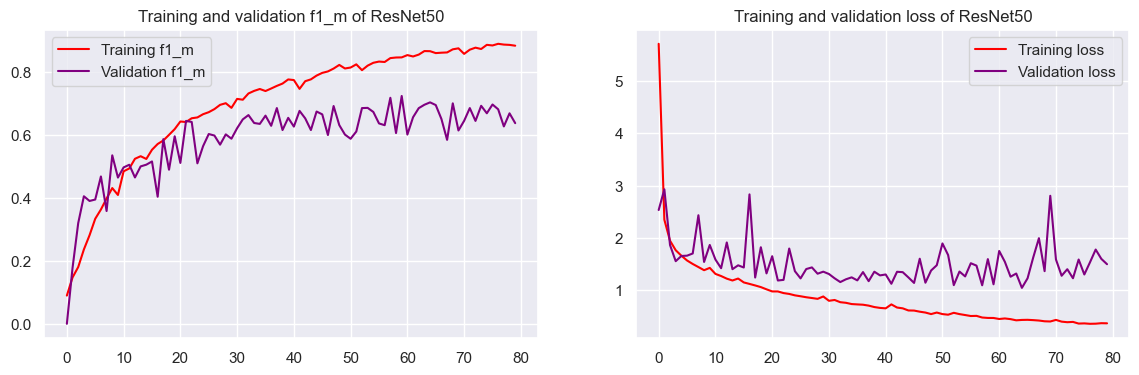

In [88]:
plot_model_history(history_restnet50, model_name='ResNet50')

In [223]:
custom_objects = {"f1_m": f1_m}
model_alexnet = keras.models.load_model('model/model_AlexNet.h5', custom_objects=custom_objects)
model_resnet = keras.models.load_model('model/model_ResNet50.h5', custom_objects=custom_objects)

In [215]:
evaluation_alexnet = model_alexnet.evaluate(test_gen)
evaluation_resnet = model_resnet.evaluate(test_gen)

14/14 [==============================] - 1s 82ms/step - loss: 1.2315 - accuracy: 0.6728 - f1_m: 0.6734


In [216]:
evaluation = np.array([evaluation_alexnet, evaluation_resnet])
evaluation_metrics = ['Loss', 'Accuracy', 'F1']
evaluation_models = ['AlexNet', 'ResNet50']
comparison = pd.DataFrame(data=evaluation, index=evaluation_models, columns=evaluation_metrics).T
comparison

,AlexNet,ResNet50
Loss,0.873385,1.231482
Accuracy,0.732719,0.672811
F1,0.747468,0.673355


In [93]:
def predict_image():
    random_row = random.randint(0, len(df)-1)
    sample = df.iloc[random_row]
    img = keras.utils.load_img(DATASET_PATH + sample['filename'], target_size = (160, 160))
    plt.imshow(img)
    img = keras.utils.img_to_array(img)
    img = img.astype('float32')/255
    img = np.expand_dims(img, axis = 0)
    print(sample['filename']) 
    prediction_alexnet = model_alexnet.predict(img)
    prediction_resnet = model_resnet.predict(img)
    max_alexnet = np.argmax(prediction_alexnet)
    max_resnet = np.argmax(prediction_resnet)
    prediction_label_alexnet = categories[max_alexnet]
    prediction_label_resnet = categories[max_resnet]
    print("AlexNet: {}\tResNet50: {}".format(prediction_label_alexnet, prediction_label_resnet))

Tana/tana_372.jpg
1/1 [==============================] - 0s 21ms/step
AlexNet: Tana	ResNet50: Tana


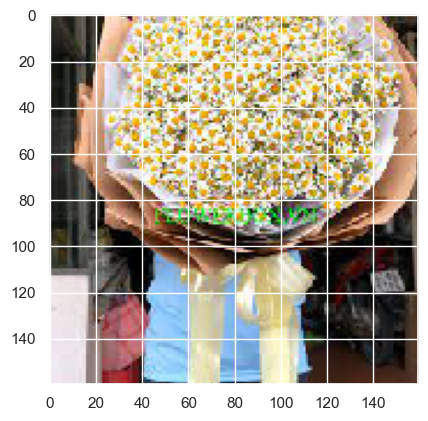

In [174]:
predict_image()